In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import numpy as np
from neicio.readstation import readStation
from neicio.shake import ShakeGrid
from openquake.hazardlib.correlation import JB2009CorrelationModel
from openquake.hazardlib.correlation import BaseCorrelationModel

from openquake.hazardlib.geo.geodetic import geodetic_distance
from openquake.hazardlib.imt import from_string
import time
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
from neicio.gmt import GMTGrid
from openquake.hazardlib.imt import PGA as IMT
import sys
sys.path.append('/Users/sverros/Documents/Modules')

from Correlation.setup import initialize
from Correlation.loop import main
from Correlation.realizations import realizations


# Variable of interest                                                                                                                                                                                                        
voi = 'PGA'
# Specify the radius of interest                                                                                                                                                                                              
r = 10
# Specify number of realizations
num_realizations = 4

# Get shakemap for desired variable, PGA, uncertainty grid and stationdata                                                                                                                                                    
# Selected Stations: Units in pctg                                                                                                                                                                                            
shakemap = ShakeGrid('/Users/sverros/Documents/Reduced_output/grid.xml', variable = '%s' % voi)

# Uncertainty Data: Units in ln(pctg)                                                                                                                                                                                         
uncertainty = ShakeGrid('/Users/sverros/Documents/Reduced_output/uncertainty.xml', variable= 'STD%s' % voi)

# Station Data: Units in pctg                                                                                                                                                                                                 
stationlist = '/Users/sverros/Documents/Reduced_output/stationlist.xml'
stationdata = readStation(stationlist)

# Used for plotting                                                                                                                                                                                                           
topofile = '/Users/sverros/Documents/etopo1_bed_g_f4.grd'


print 'Calling initialize'
variables = initialize(shakemap, uncertainty, stationdata)

print 'Calling main'
out = main(variables, r, voi)

print 'Simulating realizations'
ACCUM_ARRAY = realizations(num_realizations, variables['N'], variables['M'], out['grid_arr'], 
                           out['mu_arr'], out['sigma_arr'], variables['uncertaintydata'], out['data'])

Calling initialize
	Initialization Time: 0.38537979126
Calling main
Finishing step: 0
Finishing step: 5000
Finishing step: 10000
Finishing step: 15000
Finishing step: 20000
Finishing step: 25000
Finishing step: 30000
Total Time 13.5206410885
Pre loop Time 0.000882863998413
Inner loop time 13.0317184925
Outer loop time 0.246482133865
Simulating realizations
Done with 1 of 4 iterations.
Done with 2 of 4 iterations.
Done with 3 of 4 iterations.
Done with 4 of 4 iterations.


/Users/sverros/anaconda/lib/python2.7/site-packages/scipy/io/netcdf.py:287: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


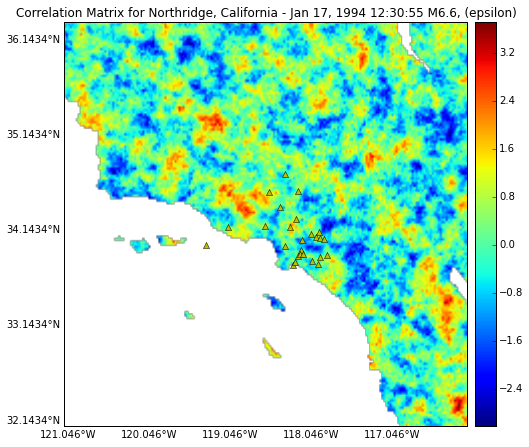

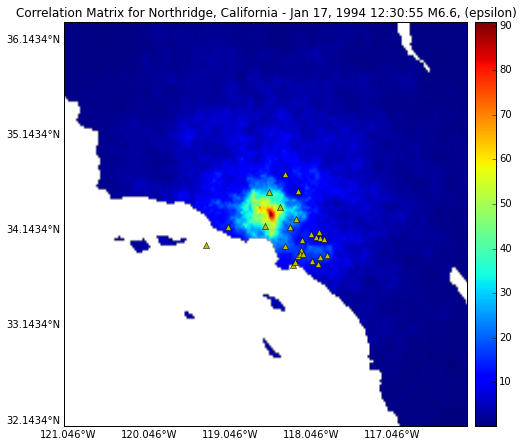

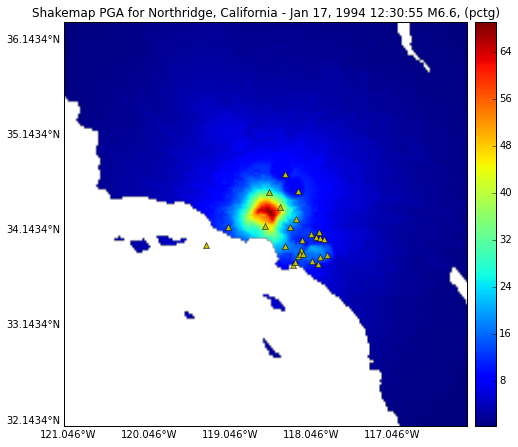

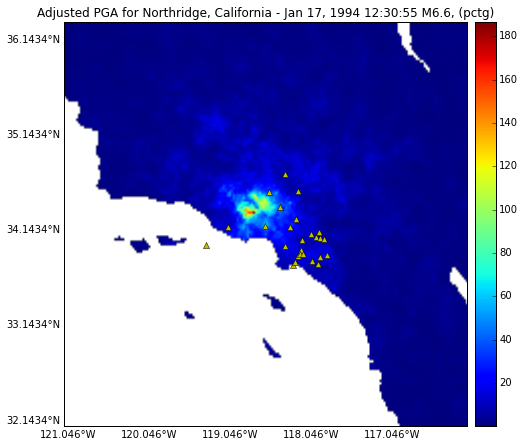

In [2]:
maxdata = np.amax(out['data_new'])
attributes = shakemap.getAttributes()
station_lons = stationdata['lon']
station_lats = stationdata['lat']

xmin,xmax,ymin,ymax = shakemap.getRange()
geodict = shakemap.getGeoDict()
xmin -= (geodict['xdim']*2)
xmax += (geodict['xdim']*2)
ymin -= (geodict['ydim']*2)
ymax += (geodict['ydim']*2)
topo = GMTGrid(topofile,bounds=(xmin,xmax,ymin,ymax))
topo.interpolateToGrid(geodict)
clear_color = [0,0,0,0.0]

CORdata = np.flipud(out['cor'].copy())
ACCUMdata = np.flipud(ACCUM_ARRAY.copy())
DATAdata = np.flipud(variables['data'].copy())
DATA_NEWdata = np.flipud(out['data_new'].copy())
topodata = np.flipud(topo.griddata.copy())
iwater = np.where(topodata < 0)

CORdata[iwater] = 0.0101
ACCUMdata[iwater] = 0.0101
DATAdata[iwater] = 0.0101
DATA_NEWdata[iwater] = 0.0101

palette = cm.jet
COR_masked = np.ma.masked_equal(CORdata, 0.0101)
ACCUM_masked = np.ma.masked_equal(ACCUMdata, 0.0101)
DATA_masked = np.ma.masked_equal(DATAdata, 0.0101)
DATA_NEW_masked = np.ma.masked_equal(DATA_NEWdata, 0.0101)

clat = ymin + (ymax-ymin)/2.0
clon = xmin + (xmax-xmin)/2.0
m = Basemap(llcrnrlon=xmin,llcrnrlat=ymin,urcrnrlon=xmax,urcrnrlat=ymax,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='i',area_thresh=1000.,projection='lcc',\
            lat_1=clat,lon_0=clon)

fig = plt.figure(figsize = (6,6))
ax = fig.add_axes([0,0,1.0,1.0])
shakemappable = m.imshow(COR_masked,cmap=palette)
plt.autoscale(False)
sta_x,sta_y = m(station_lons, station_lats)
m.plot(sta_x, sta_y, 'y^', markersize=6)
m.drawparallels(np.arange(np.min(variables['location_lat_g']),np.max(variables['location_lat_g']),1),labels=[1,0,0,0], linewidth=0.0)
m.drawmeridians(np.arange(np.min(variables['location_lon_g']),np.max(variables['location_lon_g']),1),labels=[0,0,0,1], linewidth=0.0)
locstr = attributes['event']['event_description']
mag = attributes['event']['magnitude']
datestr = attributes['event']['event_timestamp'].strftime('%b %d, %Y %H:%M:%S')
th = plt.title('Correlation Matrix for %s - %s M%.1f, (epsilon)' % (locstr,datestr,mag))
ch=m.colorbar(mappable=shakemappable)

fig = plt.figure(figsize = (6,6))
ax = fig.add_axes([0,0,1.0,1.0])
shakemappable = m.imshow(ACCUM_masked,cmap=palette)
plt.autoscale(False)
sta_x,sta_y = m(station_lons, station_lats)
m.plot(sta_x, sta_y, 'y^', markersize=6)
m.drawparallels(np.arange(np.min(variables['location_lat_g']),np.max(variables['location_lat_g']),1),labels=[1,0,0,0], linewidth=0.0)
m.drawmeridians(np.arange(np.min(variables['location_lon_g']),np.max(variables['location_lon_g']),1),labels=[0,0,0,1], linewidth=0.0)
locstr = attributes['event']['event_description']
mag = attributes['event']['magnitude']
datestr = attributes['event']['event_timestamp'].strftime('%b %d, %Y %H:%M:%S')
th = plt.title('Correlation Matrix for %s - %s M%.1f, (epsilon)' % (locstr,datestr,mag))
ch=m.colorbar(mappable=shakemappable)


fig = plt.figure(figsize = (6,6))
ax = fig.add_axes([0,0,1.0,1.0])
shakemappable = m.imshow(DATA_masked,cmap=palette)
plt.autoscale(False)
sta_x,sta_y = m(station_lons, station_lats)
m.plot(sta_x, sta_y, 'y^', markersize=6)
#plt.clim(0,maxdata)
m.drawparallels(np.arange(np.min(variables['location_lat_g']),np.max(variables['location_lat_g']),1),labels=[1,0,0,0], linewidth=0.0)
m.drawmeridians(np.arange(np.min(variables['location_lon_g']),np.max(variables['location_lon_g']),1),labels=[0,0,0,1], linewidth=0.0)
locstr = attributes['event']['event_description']
mag = attributes['event']['magnitude']
datestr = attributes['event']['event_timestamp'].strftime('%b %d, %Y %H:%M:%S')
th = plt.title('Shakemap %s for %s - %s M%.1f, (pctg)' % (voi,locstr,datestr,mag))
ch=m.colorbar(mappable=shakemappable)


fig = plt.figure(figsize = (6,6))
ax = fig.add_axes([0,0,1.0,1.0])
shakemappable = m.imshow(DATA_NEW_masked,cmap=palette)
plt.autoscale(False)
sta_x,sta_y = m(station_lons, station_lats)
m.plot(sta_x, sta_y, 'y^', markersize=6)
#plt.clim(0,maxdata)
m.drawparallels(np.arange(np.min(variables['location_lat_g']),np.max(variables['location_lat_g']),1),labels=[1,0,0,0], linewidth=0.0)
m.drawmeridians(np.arange(np.min(variables['location_lon_g']),np.max(variables['location_lon_g']),1),labels=[0,0,0,1], linewidth=0.0)
locstr = attributes['event']['event_description']
mag = attributes['event']['magnitude']
datestr = attributes['event']['event_timestamp'].strftime('%b %d, %Y %H:%M:%S')
th = plt.title('Adjusted %s for %s - %s M%.1f, (pctg)' % (voi,locstr,datestr,mag))
ch=m.colorbar(mappable=shakemappable)